### Imports and Hyperparameters

In [1]:
import imgaug as ia
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)

%matplotlib inline

In [2]:
import config

### A visualization helper function

In [3]:
def display_image(image, boxes=None, box_color=[0, 0, 255], box_thickness=3, ax=None):
    image = np.array(image)
    
    if boxes is not None:
        boxes = np.array(boxes)[..., :5]
        boxes = [ia.BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2, label=config.CLASSES[int(label)])
                 for x1, y1, x2, y2, label in boxes]
        boxes = ia.BoundingBoxesOnImage(boxes, shape=image.shape)
        image = boxes.draw_on_image(image, color=box_color,
                                    size=box_thickness)
    
    if ax is None:
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(image)
        ax.axis('off')

### Load and visualize some image

Visualize some REAL images with their boxes for sanity checking 

Loaded 1449 image samples
Loaded 581 image samples


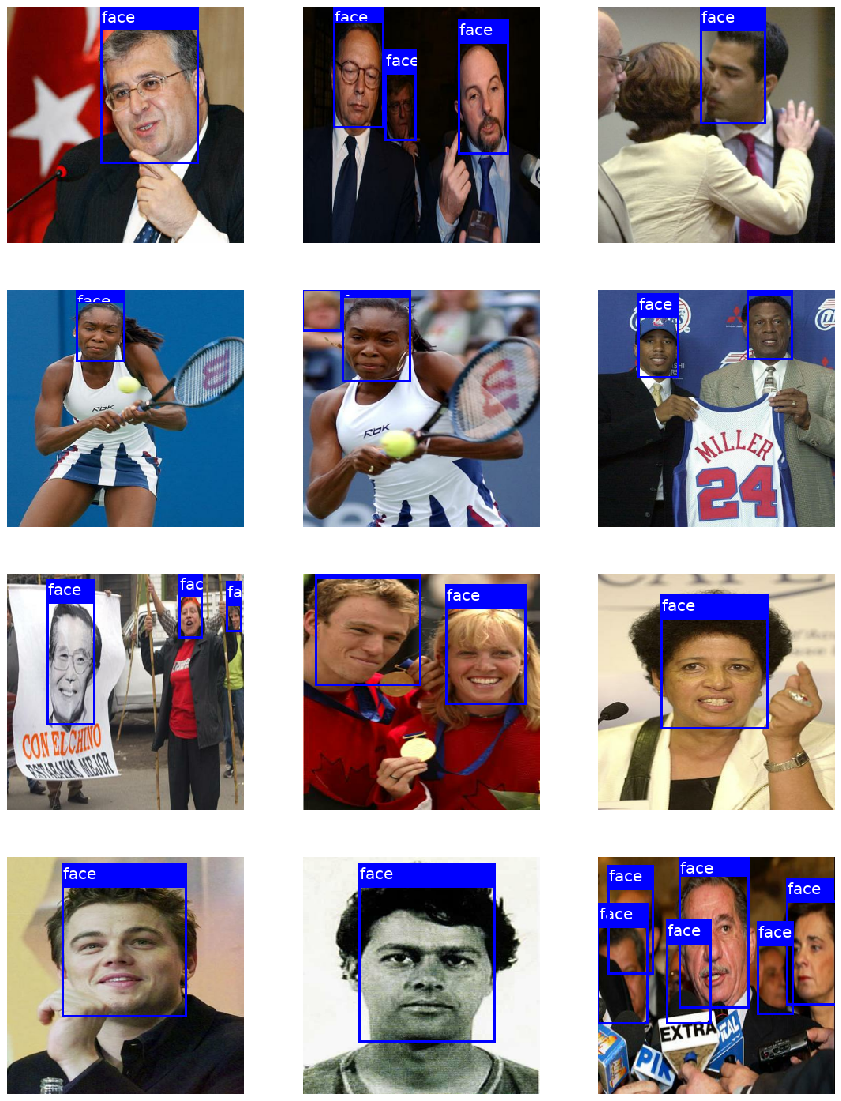

In [4]:
from faces_loader import load_faces, build_dataset

train_image_paths, train_bnd_boxes = load_faces(split='train')
valid_image_paths, valid_bnd_boxes = load_faces(split='valid')
data = build_dataset(train_image_paths, train_bnd_boxes,
                    image_size=config.IMAGE_SIZE)

num_display = 12
num_cols = 3
num_rows = (num_display+1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

data_iter = iter(data)

for idx in range(num_display):
    x, y = next(data_iter)
    display_image(x, y.to_tensor(), ax=fig.axes[idx])
    
plt.show()

Loaded 10000 image samples


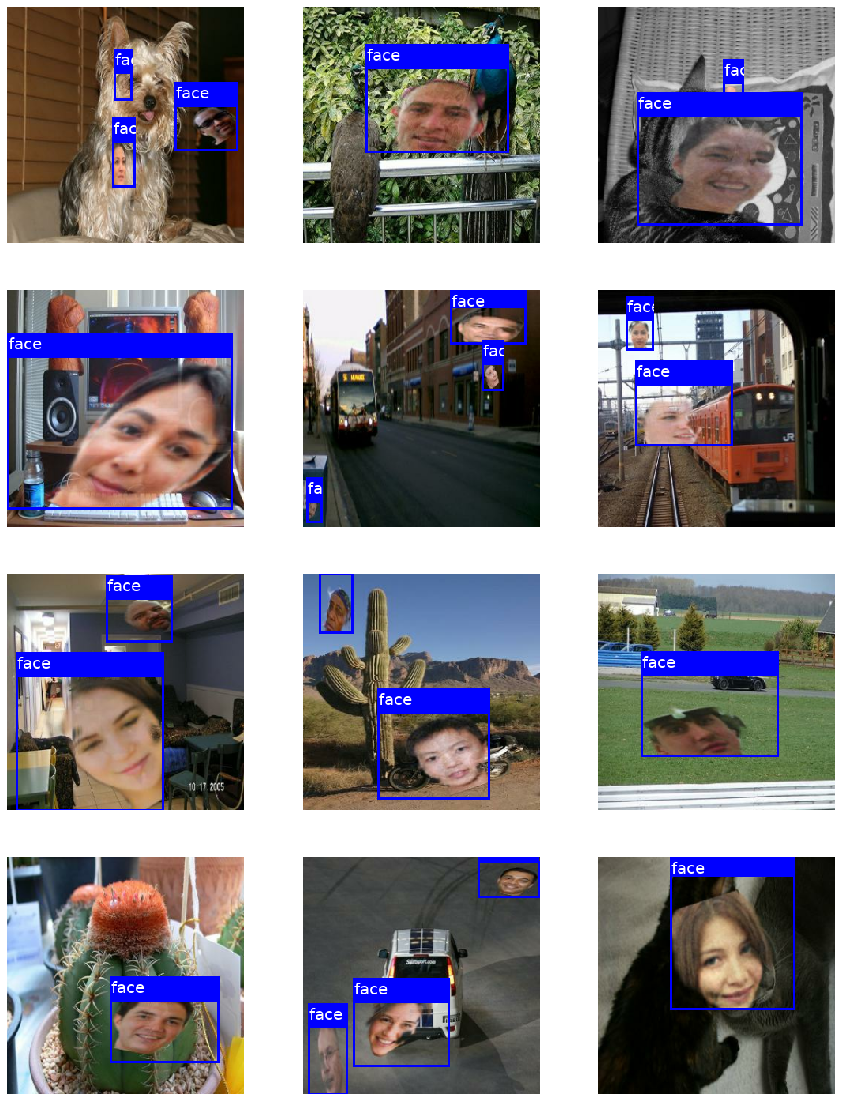

In [5]:
from faces_loader import load_faces, build_dataset

fake_image_paths, fake_bnd_boxes = load_faces(
    root=os.path.join('..', 'data', 'faces_fake'),
    split='fake')

data = build_dataset(fake_image_paths, fake_bnd_boxes,
                    image_size=config.IMAGE_SIZE)

num_display = 12
num_cols = 3
num_rows = (num_display+1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

data_iter = iter(data)

for idx in range(num_display):
    x, y = next(data_iter)
    display_image(x, y.to_tensor(), ax=fig.axes[idx])
    
plt.show()

## MobileNet

### Instantiate the model

In [6]:
from ssd_utils.networks.ssd_mobilenet import SSDMobileNet

model = SSDMobileNet(num_classes=len(config.CLASSES), name='ssd_mobilenet')

### Create the data pipelines

In [7]:
anchors = model.get_anchors(image_shape=config.IMAGE_SIZE + (3,))

fake_data = build_dataset(fake_image_paths, fake_bnd_boxes,
                          image_size=config.IMAGE_SIZE,
                          batch_size=config.BATCH_SIZE,
                          repeat=True, shuffle=True,
                          encode_output=True,
                          anchors=anchors,
                          model=model)

train_data = build_dataset(train_image_paths, train_bnd_boxes,
                           image_size=config.IMAGE_SIZE,
                           batch_size=config.BATCH_SIZE,
                           repeat=True, shuffle=True,
                           encode_output=True,
                           anchors=anchors,
                           model=model)

valid_data = build_dataset(valid_image_paths, valid_bnd_boxes,
                           image_size=config.IMAGE_SIZE,
                           batch_size=config.BATCH_SIZE,
                           repeat=False, shuffle=False,
                           encode_output=False)

for data in [fake_data, train_data, valid_data]:
    x, y = next(iter(data))
    print(x.shape, y.shape)

(16, 300, 300, 3) (16, 2430, 6)
(16, 300, 300, 3) (16, 2430, 6)
(16, 300, 300, 3) (16, None, None)


### Pretrain the model on fake data

In [8]:
from ssd_utils.ssd_loss import SSDLoss
from ssd_utils.metrics import MeanAveragePrecision
from tensorflow.keras.callbacks import ModelCheckpoint

from ssd_utils import output_encoder
from utils import MeanAveragePrecisionCallback

ssd_loss = SSDLoss()
        
meanAP_callback = MeanAveragePrecisionCallback(data=valid_data,
                                               anchors=anchors)

ckpt_callback = ModelCheckpoint('mobilenet_pretrain.h5',
                                monitor='val_meanAP',
                                mode='max',
                                save_best_only=True,
                                save_weights_only=True)        

        
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=ssd_loss)

history = model.fit(fake_data, epochs=config.NUM_EPOCHS * 2,
          steps_per_epoch=config.STEPS_PER_EPOCH,
          callbacks=[meanAP_callback, ckpt_callback])

Epoch 1/40
25/25 [==============================] - ETA: 0s - loss: 42.2973

Calculating Average Precision...: 20it [00:00, 188.69it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 195.40it/s]


25/25 [==============================] - 26s 1s/step - loss: 42.2973 - val_meanAP: 0.0098
Epoch 2/40
25/25 [==============================] - ETA: 0s - loss: 6.8919

Calculating Average Precision...: 15it [00:00, 125.17it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:05, 103.09it/s]


25/25 [==============================] - 33s 1s/step - loss: 6.8919 - val_meanAP: 0.0447
Epoch 3/40
25/25 [==============================] - ETA: 0s - loss: 5.3673

Calculating Average Precision...: 16it [00:00, 155.60it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:04, 134.93it/s]


25/25 [==============================] - 30s 1s/step - loss: 5.3673 - val_meanAP: 0.1150
Epoch 4/40
25/25 [==============================] - ETA: 0s - loss: 4.4223

Calculating Average Precision...: 16it [00:00, 157.04it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:04, 140.09it/s]


25/25 [==============================] - 30s 1s/step - loss: 4.4223 - val_meanAP: 0.1706
Epoch 5/40
25/25 [==============================] - ETA: 0s - loss: 3.9142

Calculating Average Precision...: 15it [00:00, 126.46it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:04, 121.21it/s]


25/25 [==============================] - 30s 1s/step - loss: 3.9142 - val_meanAP: 0.2668
Epoch 6/40
25/25 [==============================] - ETA: 0s - loss: 3.6134

Calculating Average Precision...: 15it [00:00, 140.98it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:05, 108.30it/s]


25/25 [==============================] - 31s 1s/step - loss: 3.6134 - val_meanAP: 0.2947
Epoch 7/40
25/25 [==============================] - ETA: 0s - loss: 3.3393

Calculating Average Precision...: 16it [00:00, 148.60it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:03, 148.90it/s]


25/25 [==============================] - 28s 1s/step - loss: 3.3393 - val_meanAP: 0.3815
Epoch 8/40
25/25 [==============================] - ETA: 0s - loss: 3.0528

Calculating Average Precision...: 14it [00:00, 127.46it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:04, 134.40it/s]

25/25 [==============================] - 27s 1s/step - loss: 3.0528 - val_meanAP: 0.3489


Epoch 9/40
25/25 [==============================] - ETA: 0s - loss: 2.8423

Calculating Average Precision...: 17it [00:00, 160.93it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:03, 161.24it/s]


25/25 [==============================] - 26s 1s/step - loss: 2.8423 - val_meanAP: 0.4241
Epoch 10/40
25/25 [==============================] - ETA: 0s - loss: 2.6634

Calculating Average Precision...: 17it [00:00, 164.77it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:03, 162.00it/s]

25/25 [==============================] - 27s 1s/step - loss: 2.6634 - val_meanAP: 0.4131


Epoch 11/40
25/25 [==============================] - ETA: 0s - loss: 2.5491

Calculating Average Precision...: 18it [00:00, 161.76it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:03, 168.30it/s]

25/25 [==============================] - 26s 1s/step - loss: 2.5491 - val_meanAP: 0.3601


Epoch 12/40
25/25 [==============================] - ETA: 0s - loss: 2.5160

Calculating Average Precision...: 18it [00:00, 164.22it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:03, 192.12it/s]

25/25 [==============================] - 24s 971ms/step - loss: 2.5160 - val_meanAP: 0.3525


Epoch 13/40
25/25 [==============================] - ETA: 0s - loss: 2.3163

Calculating Average Precision...: 16it [00:00, 157.56it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:03, 181.30it/s]

25/25 [==============================] - 24s 975ms/step - loss: 2.3163 - val_meanAP: 0.4148


Epoch 14/40
25/25 [==============================] - ETA: 0s - loss: 2.2231

Calculating Average Precision...: 18it [00:00, 178.39it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 198.86it/s]

25/25 [==============================] - 24s 975ms/step - loss: 2.2231 - val_meanAP: 0.2954


Epoch 15/40
25/25 [==============================] - ETA: 0s - loss: 2.1555

Calculating Average Precision...: 17it [00:00, 151.77it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:03, 178.87it/s]

25/25 [==============================] - 26s 1s/step - loss: 2.1555 - val_meanAP: 0.2612


Epoch 16/40
25/25 [==============================] - ETA: 0s - loss: 2.0696

Calculating Average Precision...: 20it [00:00, 191.73it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:03, 193.00it/s]


25/25 [==============================] - 26s 1s/step - loss: 2.0696 - val_meanAP: 0.4347
Epoch 17/40
25/25 [==============================] - ETA: 0s - loss: 2.0205

Calculating Average Precision...: 22it [00:00, 219.62it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 225.04it/s]


25/25 [==============================] - 24s 949ms/step - loss: 2.0205 - val_meanAP: 0.4514
Epoch 18/40
25/25 [==============================] - ETA: 0s - loss: 2.0110

Calculating Average Precision...: 17it [00:00, 163.63it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 203.42it/s]


25/25 [==============================] - 25s 998ms/step - loss: 2.0110 - val_meanAP: 0.4588
Epoch 19/40
25/25 [==============================] - ETA: 0s - loss: 1.9777

Calculating Average Precision...: 18it [00:00, 172.40it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 255.23it/s]

25/25 [==============================] - 24s 940ms/step - loss: 1.9777 - val_meanAP: 0.4188


Epoch 20/40
25/25 [==============================] - ETA: 0s - loss: 1.9373

Calculating Average Precision...: 24it [00:00, 229.10it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 211.82it/s]


25/25 [==============================] - 25s 991ms/step - loss: 1.9373 - val_meanAP: 0.4836
Epoch 21/40
25/25 [==============================] - ETA: 0s - loss: 1.8628

Calculating Average Precision...: 18it [00:00, 166.04it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 194.72it/s]


25/25 [==============================] - 25s 1s/step - loss: 1.8628 - val_meanAP: 0.4852
Epoch 22/40
25/25 [==============================] - ETA: 0s - loss: 1.8429

Calculating Average Precision...: 18it [00:00, 175.48it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 199.41it/s]


25/25 [==============================] - 26s 1s/step - loss: 1.8429 - val_meanAP: 0.5657
Epoch 23/40
25/25 [==============================] - ETA: 0s - loss: 1.7978

Calculating Average Precision...: 26it [00:00, 251.66it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 220.02it/s]

25/25 [==============================] - 26s 1s/step - loss: 1.7978 - val_meanAP: 0.5649


Epoch 24/40
25/25 [==============================] - ETA: 0s - loss: 1.7789

Calculating Average Precision...: 21it [00:00, 200.52it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 228.63it/s]

25/25 [==============================] - 27s 1s/step - loss: 1.7789 - val_meanAP: 0.4672


Epoch 25/40
25/25 [==============================] - ETA: 0s - loss: 1.6916

Calculating Average Precision...: 18it [00:00, 177.95it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 232.42it/s]

25/25 [==============================] - 26s 1s/step - loss: 1.6916 - val_meanAP: 0.5553


Epoch 26/40
25/25 [==============================] - ETA: 0s - loss: 1.6304

Calculating Average Precision...: 21it [00:00, 201.98it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 216.89it/s]


25/25 [==============================] - 25s 988ms/step - loss: 1.6304 - val_meanAP: 0.6373
Epoch 27/40
25/25 [==============================] - ETA: 0s - loss: 1.5832

Calculating Average Precision...: 23it [00:00, 222.33it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 282.86it/s]

25/25 [==============================] - 23s 924ms/step - loss: 1.5832 - val_meanAP: 0.5171


Epoch 28/40
25/25 [==============================] - ETA: 0s - loss: 1.6066

Calculating Average Precision...: 23it [00:00, 218.54it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 262.16it/s]

25/25 [==============================] - 23s 937ms/step - loss: 1.6066 - val_meanAP: 0.4652


Epoch 29/40
25/25 [==============================] - ETA: 0s - loss: 1.5271

Calculating Average Precision...: 28it [00:00, 279.57it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 282.52it/s]

25/25 [==============================] - 23s 930ms/step - loss: 1.5271 - val_meanAP: 0.6037


Epoch 30/40
25/25 [==============================] - ETA: 0s - loss: 1.5356

Calculating Average Precision...: 22it [00:00, 219.60it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 262.71it/s]

25/25 [==============================] - 23s 939ms/step - loss: 1.5356 - val_meanAP: 0.5607


Epoch 31/40
25/25 [==============================] - ETA: 0s - loss: 1.5109

Calculating Average Precision...: 24it [00:00, 238.18it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 250.43it/s]


25/25 [==============================] - 23s 927ms/step - loss: 1.5109 - val_meanAP: 0.5957
Epoch 32/40
25/25 [==============================] - ETA: 0s - loss: 1.5140

Calculating Average Precision...: 24it [00:00, 234.50it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 270.29it/s]

25/25 [==============================] - 23s 924ms/step - loss: 1.5140 - val_meanAP: 0.6178


Epoch 33/40
25/25 [==============================] - ETA: 0s - loss: 1.3887

Calculating Average Precision...: 27it [00:00, 264.91it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 267.13it/s]

25/25 [==============================] - 23s 914ms/step - loss: 1.3887 - val_meanAP: 0.6125


Epoch 34/40
25/25 [==============================] - ETA: 0s - loss: 1.4202

Calculating Average Precision...: 31it [00:00, 306.63it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 356.74it/s]

25/25 [==============================] - 21s 851ms/step - loss: 1.4202 - val_meanAP: 0.5924


Epoch 35/40
25/25 [==============================] - ETA: 0s - loss: 1.3990

Calculating Average Precision...: 28it [00:00, 274.64it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 335.74it/s]

25/25 [==============================] - 21s 822ms/step - loss: 1.3990 - val_meanAP: 0.5446


Epoch 36/40
25/25 [==============================] - ETA: 0s - loss: 1.3789

Calculating Average Precision...: 28it [00:00, 277.01it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 333.72it/s]

25/25 [==============================] - 20s 814ms/step - loss: 1.3789 - val_meanAP: 0.6177


Epoch 37/40
25/25 [==============================] - ETA: 0s - loss: 1.3761

Calculating Average Precision...: 34it [00:00, 329.03it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 290.82it/s]

25/25 [==============================] - 21s 860ms/step - loss: 1.3761 - val_meanAP: 0.5688


Epoch 38/40
25/25 [==============================] - ETA: 0s - loss: 1.3524

Calculating Average Precision...: 34it [00:00, 335.26it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 330.27it/s]

25/25 [==============================] - 21s 852ms/step - loss: 1.3524 - val_meanAP: 0.5838


Epoch 39/40
25/25 [==============================] - ETA: 0s - loss: 1.3870

Calculating Average Precision...: 40it [00:00, 389.32it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 346.12it/s]

25/25 [==============================] - 21s 833ms/step - loss: 1.3870 - val_meanAP: 0.4585


Epoch 40/40
25/25 [==============================] - ETA: 0s - loss: 1.3105

Calculating Average Precision...: 28it [00:00, 267.04it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 312.92it/s]

25/25 [==============================] - 22s 872ms/step - loss: 1.3105 - val_meanAP: 0.4970


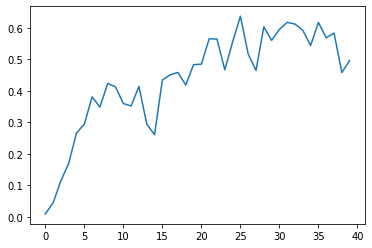

In [9]:
plt.plot(history.history['val_meanAP'])

Calculating Average Precision...: 32it [00:00, 317.02it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 336.74it/s]


Validation meanAP: tf.Tensor(0.6618228926125412, shape=(), dtype=float64)


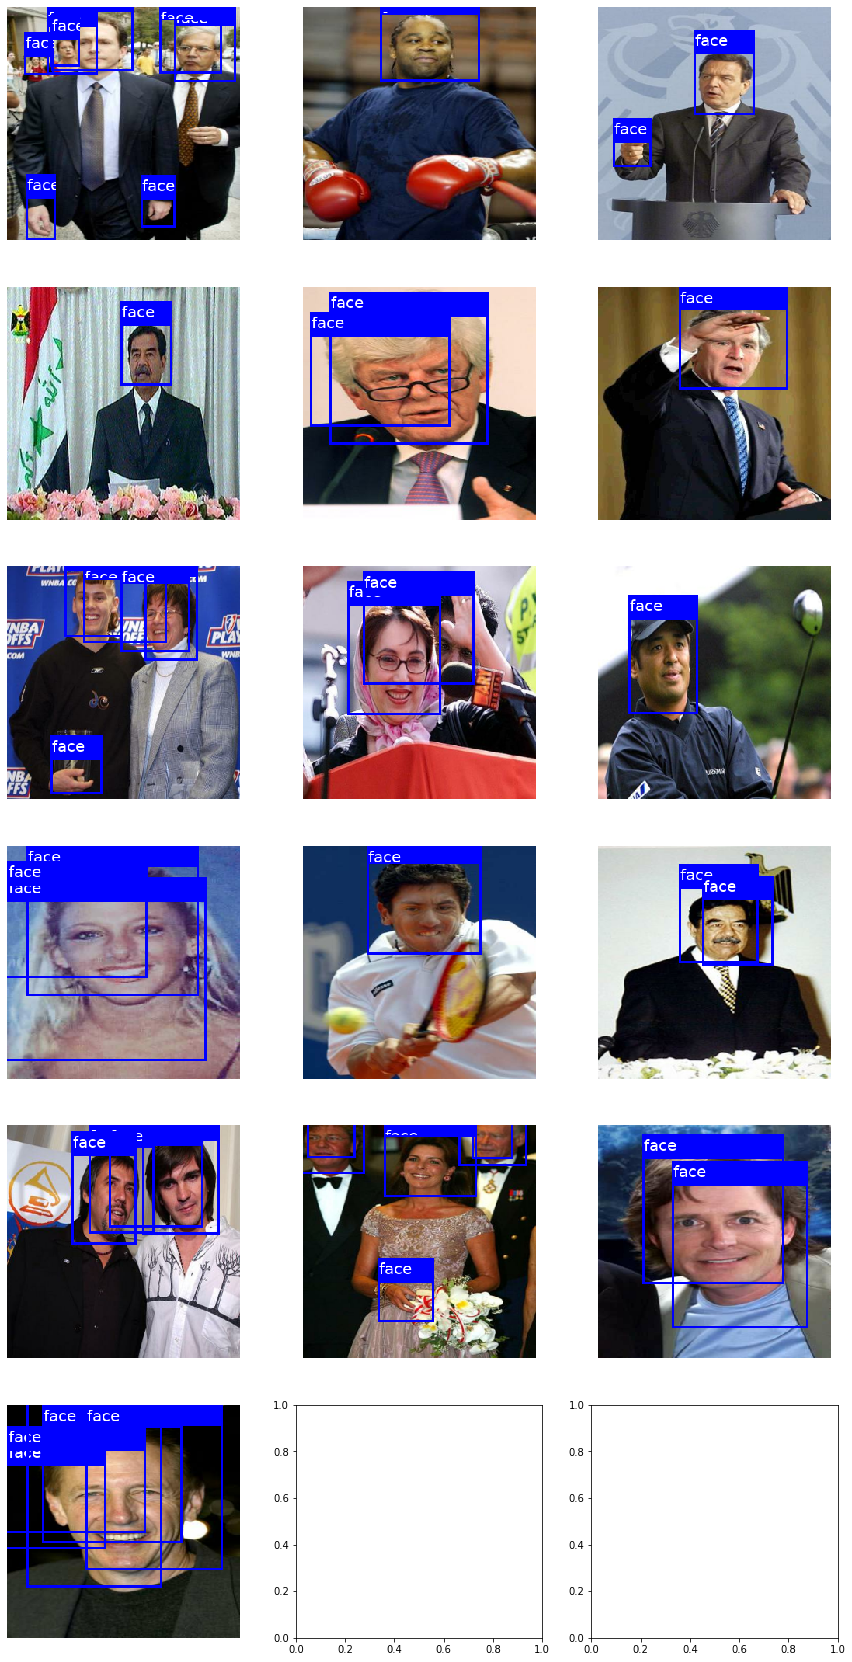

In [15]:
from ssd_utils.metrics import MeanAveragePrecision

mean_AP_metric = MeanAveragePrecision()

model_file = 'mobilenet_pretrain.h5'
model.load_weights(model_file)

for x, y_true in valid_data:
    predictions = [output_encoder.decode(y, anchors, model)
                   for y in model(x)]
    ground_truth = [y.to_tensor() for y in y_true]
    mean_AP_metric.update_state(ground_truth, predictions)

print('Validation meanAP:', mean_AP_metric.result())
mean_AP_metric.reset_state()     

num_display = 16
num_cols = 3
num_rows = (num_display+num_cols-1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

X, Y = next(iter(valid_data))
Y_pred = model(X)

for idx in range(num_display):
    x = X[idx]
    y = output_encoder.decode(Y_pred[idx], anchors, model)
    display_image(x, y, ax=fig.axes[idx])
    
plt.show()

### Fintetune the model on real data

In [16]:
from ssd_utils.ssd_loss import SSDLoss
from ssd_utils.metrics import MeanAveragePrecision
from tensorflow.keras.callbacks import ModelCheckpoint

from ssd_utils import output_encoder
from utils import MeanAveragePrecisionCallback

ssd_loss = SSDLoss()
        
meanAP_callback = MeanAveragePrecisionCallback(data=valid_data,
                                               anchors=anchors)

ckpt_callback = ModelCheckpoint('mobilenet_finetune.h5',
                                monitor='val_meanAP',
                                mode='max',
                                save_best_only=True,
                                save_weights_only=True)        

        
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=ssd_loss)

history = model.fit(train_data, epochs=config.NUM_EPOCHS,
          steps_per_epoch=config.STEPS_PER_EPOCH,
          callbacks=[meanAP_callback, ckpt_callback])

Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 1.6966

Calculating Average Precision...: 49it [00:00, 488.51it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 518.01it/s]

25/25 [==============================] - 19s 747ms/step - loss: 1.6966 - val_meanAP: 0.7773


Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 1.2734

Calculating Average Precision...: 49it [00:00, 485.33it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 489.39it/s]

25/25 [==============================] - 19s 744ms/step - loss: 1.2734 - val_meanAP: 0.7587


Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 1.0907

Calculating Average Precision...: 51it [00:00, 503.73it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 532.02it/s]


25/25 [==============================] - 19s 759ms/step - loss: 1.0907 - val_meanAP: 0.7846
Epoch 4/20
25/25 [==============================] - ETA: 0s - loss: 0.9263

Calculating Average Precision...: 62it [00:00, 607.41it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 569.41it/s]


25/25 [==============================] - 21s 836ms/step - loss: 0.9263 - val_meanAP: 0.7984
Epoch 5/20
25/25 [==============================] - ETA: 0s - loss: 0.8450

Calculating Average Precision...: 54it [00:00, 535.90it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 511.39it/s]


25/25 [==============================] - 19s 778ms/step - loss: 0.8450 - val_meanAP: 0.8134
Epoch 6/20
25/25 [==============================] - ETA: 0s - loss: 0.7728

Calculating Average Precision...: 56it [00:00, 544.53it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 518.65it/s]

25/25 [==============================] - 19s 750ms/step - loss: 0.7728 - val_meanAP: 0.8128


Epoch 7/20
25/25 [==============================] - ETA: 0s - loss: 0.7109

Calculating Average Precision...: 54it [00:00, 528.21it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 536.97it/s]


25/25 [==============================] - 19s 771ms/step - loss: 0.7109 - val_meanAP: 0.8196
Epoch 8/20
25/25 [==============================] - ETA: 0s - loss: 0.7129

Calculating Average Precision...: 44it [00:00, 430.03it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 461.93it/s]


25/25 [==============================] - 21s 836ms/step - loss: 0.7129 - val_meanAP: 0.8332
Epoch 9/20
25/25 [==============================] - ETA: 0s - loss: 0.6524

Calculating Average Precision...: 56it [00:00, 549.00it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 543.41it/s]


25/25 [==============================] - 21s 823ms/step - loss: 0.6524 - val_meanAP: 0.8333
Epoch 10/20
25/25 [==============================] - ETA: 0s - loss: 0.6294

Calculating Average Precision...: 55it [00:00, 548.33it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 528.03it/s]


25/25 [==============================] - 19s 765ms/step - loss: 0.6294 - val_meanAP: 0.8428
Epoch 11/20
25/25 [==============================] - ETA: 0s - loss: 0.5380

Calculating Average Precision...: 61it [00:00, 601.41it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 530.86it/s]


25/25 [==============================] - 19s 750ms/step - loss: 0.5380 - val_meanAP: 0.8510
Epoch 12/20
25/25 [==============================] - ETA: 0s - loss: 0.5080

Calculating Average Precision...: 56it [00:00, 541.34it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 530.04it/s]

25/25 [==============================] - 19s 762ms/step - loss: 0.5080 - val_meanAP: 0.8425


Epoch 13/20
25/25 [==============================] - ETA: 0s - loss: 0.5072

Calculating Average Precision...: 54it [00:00, 530.86it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 559.87it/s]

25/25 [==============================] - 19s 754ms/step - loss: 0.5072 - val_meanAP: 0.8492


Epoch 14/20
25/25 [==============================] - ETA: 0s - loss: 0.4728

Calculating Average Precision...: 52it [00:00, 519.29it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 547.65it/s]


25/25 [==============================] - 19s 759ms/step - loss: 0.4728 - val_meanAP: 0.8537
Epoch 15/20
25/25 [==============================] - ETA: 0s - loss: 0.4261

Calculating Average Precision...: 54it [00:00, 530.78it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 525.25it/s]

25/25 [==============================] - 19s 763ms/step - loss: 0.4261 - val_meanAP: 0.8518


Epoch 16/20
25/25 [==============================] - ETA: 0s - loss: 0.4322

Calculating Average Precision...: 50it [00:00, 493.60it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 494.76it/s]


25/25 [==============================] - 19s 758ms/step - loss: 0.4322 - val_meanAP: 0.8548
Epoch 17/20
25/25 [==============================] - ETA: 0s - loss: 0.4019

Calculating Average Precision...: 54it [00:00, 535.42it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 505.18it/s]

25/25 [==============================] - 19s 766ms/step - loss: 0.4019 - val_meanAP: 0.8521


Epoch 18/20
25/25 [==============================] - ETA: 0s - loss: 0.3913

Calculating Average Precision...: 69it [00:00, 681.67it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:00, 608.62it/s]


25/25 [==============================] - 19s 759ms/step - loss: 0.3913 - val_meanAP: 0.8564
Epoch 19/20
25/25 [==============================] - ETA: 0s - loss: 0.3812

Calculating Average Precision...: 49it [00:00, 487.15it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 519.60it/s]


25/25 [==============================] - 21s 848ms/step - loss: 0.3812 - val_meanAP: 0.8609
Epoch 20/20
25/25 [==============================] - ETA: 0s - loss: 0.3553

Calculating Average Precision...: 55it [00:00, 546.77it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 488.55it/s]

25/25 [==============================] - 19s 762ms/step - loss: 0.3553 - val_meanAP: 0.8594


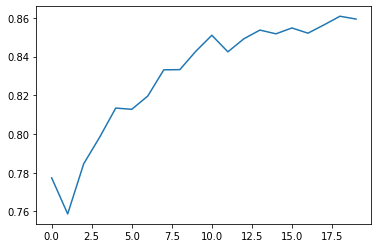

In [17]:
plt.plot(history.history['val_meanAP'])

Calculating Average Precision...: 51it [00:00, 509.35it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 485.50it/s]


Validation meanAP: tf.Tensor(0.8608582143426, shape=(), dtype=float64)


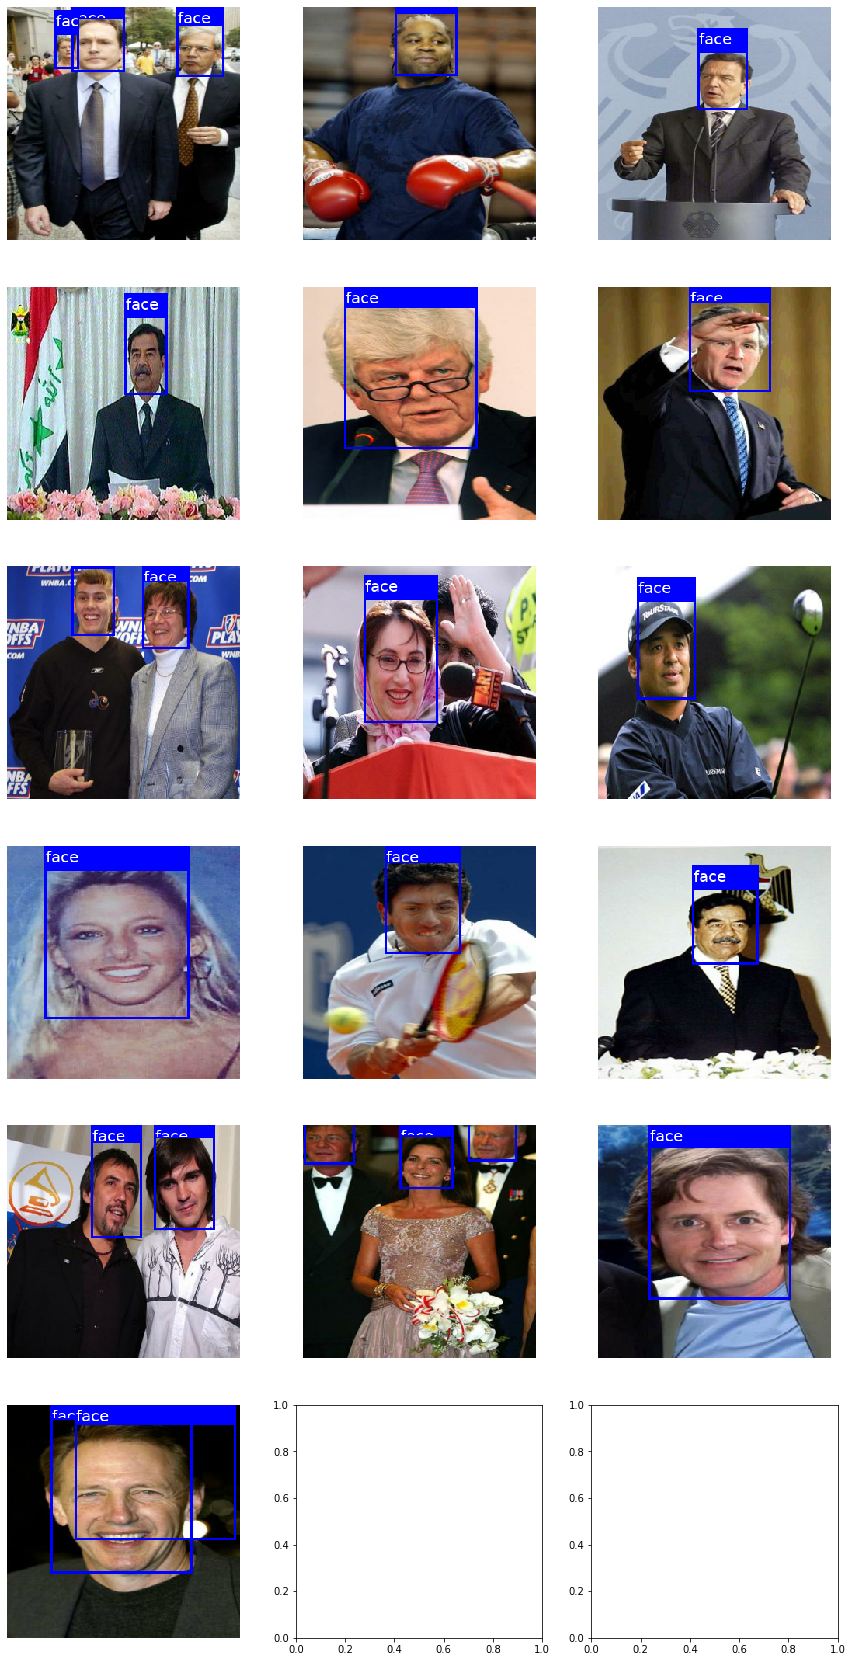

In [10]:
from ssd_utils.metrics import MeanAveragePrecision

mean_AP_metric = MeanAveragePrecision()

model_file = 'mobilenet_finetune.h5'
model.load_weights(model_file)

for x, y_true in valid_data:
    predictions = [output_encoder.decode(y, anchors, model)
                   for y in model(x)]
    ground_truth = [y.to_tensor() for y in y_true]
    mean_AP_metric.update_state(ground_truth, predictions)

print('Validation meanAP:', mean_AP_metric.result())
mean_AP_metric.reset_state()     

num_display = 16
num_cols = 3
num_rows = (num_display+num_cols-1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

X, Y = next(iter(valid_data))
Y_pred = model(X)

for idx in range(num_display):
    x = X[idx]
    y = output_encoder.decode(Y_pred[idx], anchors, model)
    display_image(x, y, ax=fig.axes[idx])
    
plt.show()

## ResNet50

### Instantiate the model

In [11]:
from ssd_utils.networks.ssd_resnet50 import SSDResNet50

model = SSDResNet50(num_classes=len(config.CLASSES), name='ssd_resnet50')

### Create the data pipelines

In [12]:
anchors = model.get_anchors(image_shape=config.IMAGE_SIZE + (3,))

fake_data = build_dataset(fake_image_paths, fake_bnd_boxes,
                          image_size=config.IMAGE_SIZE,
                          batch_size=config.BATCH_SIZE,
                          repeat=True, shuffle=True,
                          encode_output=True,
                          anchors=anchors,
                          model=model)

train_data = build_dataset(train_image_paths, train_bnd_boxes,
                           image_size=config.IMAGE_SIZE,
                           batch_size=config.BATCH_SIZE,
                           repeat=True, shuffle=True,
                           encode_output=True,
                           anchors=anchors,
                           model=model)

valid_data = build_dataset(valid_image_paths, valid_bnd_boxes,
                           image_size=config.IMAGE_SIZE,
                           batch_size=config.BATCH_SIZE,
                           repeat=False, shuffle=False,
                           encode_output=False)

for data in [fake_data, train_data, valid_data]:
    x, y = next(iter(data))
    print(x.shape, y.shape)

(16, 300, 300, 3) (16, 4149, 6)
(16, 300, 300, 3) (16, 4149, 6)
(16, 300, 300, 3) (16, None, None)


### Pretrain the model on fake data

In [13]:
from ssd_utils.ssd_loss import SSDLoss
from ssd_utils.metrics import MeanAveragePrecision
from tensorflow.keras.callbacks import ModelCheckpoint

from ssd_utils import output_encoder
from utils import MeanAveragePrecisionCallback

ssd_loss = SSDLoss()
        
meanAP_callback = MeanAveragePrecisionCallback(data=valid_data,
                                               anchors=anchors)

ckpt_callback = ModelCheckpoint('resnet50_pretrain.h5',
                                monitor='val_meanAP',
                                mode='max',
                                save_best_only=True,
                                save_weights_only=True)        

        
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=ssd_loss)

history = model.fit(fake_data, epochs=config.NUM_EPOCHS * 2,
          steps_per_epoch=config.STEPS_PER_EPOCH,
          callbacks=[meanAP_callback, ckpt_callback])

Epoch 1/40
25/25 [==============================] - ETA: 0s - loss: 24.2819

Calculating Average Precision...: 16it [00:00, 157.12it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:04, 131.90it/s]


25/25 [==============================] - 37s 1s/step - loss: 24.2819 - val_meanAP: 0.1006
Epoch 2/40
25/25 [==============================] - ETA: 0s - loss: 4.4562

Calculating Average Precision...: 10it [00:00, 84.26it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:06, 85.83it/s]


25/25 [==============================] - 45s 2s/step - loss: 4.4562 - val_meanAP: 0.1387
Epoch 3/40
25/25 [==============================] - ETA: 0s - loss: 2.9786

Calculating Average Precision...: 11it [00:00, 96.69it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:06, 92.06it/s] 


25/25 [==============================] - 43s 2s/step - loss: 2.9786 - val_meanAP: 0.2688
Epoch 4/40
25/25 [==============================] - ETA: 0s - loss: 2.6306

Calculating Average Precision...: 9it [00:00, 81.87it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:07, 77.09it/s]


25/25 [==============================] - 50s 2s/step - loss: 2.6306 - val_meanAP: 0.4474
Epoch 5/40
25/25 [==============================] - ETA: 0s - loss: 2.3884

Calculating Average Precision...: 13it [00:00, 121.37it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:06, 95.64it/s] 


25/25 [==============================] - 44s 2s/step - loss: 2.3884 - val_meanAP: 0.5071
Epoch 6/40
25/25 [==============================] - ETA: 0s - loss: 2.1063

Calculating Average Precision...: 11it [00:00, 103.84it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:05, 99.03it/s] 


25/25 [==============================] - 44s 2s/step - loss: 2.1063 - val_meanAP: 0.6117
Epoch 7/40
25/25 [==============================] - ETA: 0s - loss: 2.0071

Calculating Average Precision...: 13it [00:00, 124.43it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:05, 111.46it/s]

25/25 [==============================] - 41s 2s/step - loss: 2.0071 - val_meanAP: 0.6070


Epoch 8/40
25/25 [==============================] - ETA: 0s - loss: 1.7951

Calculating Average Precision...: 15it [00:00, 140.16it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:04, 128.74it/s]


25/25 [==============================] - 41s 2s/step - loss: 1.7951 - val_meanAP: 0.6190
Epoch 9/40
25/25 [==============================] - ETA: 0s - loss: 1.7708

Calculating Average Precision...: 16it [00:00, 149.65it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:06, 92.83it/s] 


25/25 [==============================] - 48s 2s/step - loss: 1.7708 - val_meanAP: 0.6736
Epoch 10/40
25/25 [==============================] - ETA: 0s - loss: 1.7172

Calculating Average Precision...: 18it [00:00, 172.03it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:03, 153.92it/s]

25/25 [==============================] - 37s 1s/step - loss: 1.7172 - val_meanAP: 0.6188


Epoch 11/40
25/25 [==============================] - ETA: 0s - loss: 1.5864

Calculating Average Precision...: 18it [00:00, 178.47it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:03, 158.63it/s]

25/25 [==============================] - 37s 1s/step - loss: 1.5864 - val_meanAP: 0.6397


Epoch 12/40
25/25 [==============================] - ETA: 0s - loss: 1.6272

Calculating Average Precision...: 17it [00:00, 160.22it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:03, 174.92it/s]

25/25 [==============================] - 40s 2s/step - loss: 1.6272 - val_meanAP: 0.6242


Epoch 13/40
25/25 [==============================] - ETA: 0s - loss: 1.5257

Calculating Average Precision...: 18it [00:00, 158.84it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:03, 189.38it/s]

25/25 [==============================] - 39s 2s/step - loss: 1.5257 - val_meanAP: 0.6508


Epoch 14/40
25/25 [==============================] - ETA: 0s - loss: 1.4932

Calculating Average Precision...: 15it [00:00, 148.91it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:03, 188.66it/s]

25/25 [==============================] - 36s 1s/step - loss: 1.4932 - val_meanAP: 0.6488


Epoch 15/40
25/25 [==============================] - ETA: 0s - loss: 1.3130

Calculating Average Precision...: 18it [00:00, 172.86it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:03, 172.82it/s]

25/25 [==============================] - 37s 1s/step - loss: 1.3130 - val_meanAP: 0.6054


Epoch 16/40
25/25 [==============================] - ETA: 0s - loss: 1.2931

Calculating Average Precision...: 21it [00:00, 205.16it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:03, 184.54it/s]

25/25 [==============================] - 37s 1s/step - loss: 1.2931 - val_meanAP: 0.6634


Epoch 17/40
25/25 [==============================] - ETA: 0s - loss: 1.3581

Calculating Average Precision...: 18it [00:00, 158.01it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:03, 169.74it/s]

25/25 [==============================] - 38s 2s/step - loss: 1.3581 - val_meanAP: 0.5940


Epoch 18/40
25/25 [==============================] - ETA: 0s - loss: 1.2869

Calculating Average Precision...: 22it [00:00, 210.14it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 205.43it/s]

25/25 [==============================] - 34s 1s/step - loss: 1.2869 - val_meanAP: 0.6304


Epoch 19/40
25/25 [==============================] - ETA: 0s - loss: 1.3268

Calculating Average Precision...: 18it [00:00, 177.32it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 243.22it/s]

25/25 [==============================] - 31s 1s/step - loss: 1.3268 - val_meanAP: 0.5782


Epoch 20/40
25/25 [==============================] - ETA: 0s - loss: 1.2949

Calculating Average Precision...: 21it [00:00, 209.98it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 252.93it/s]

25/25 [==============================] - 31s 1s/step - loss: 1.2949 - val_meanAP: 0.6498


Epoch 21/40
25/25 [==============================] - ETA: 0s - loss: 1.2893

Calculating Average Precision...: 26it [00:00, 253.05it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 282.15it/s]

25/25 [==============================] - 30s 1s/step - loss: 1.2893 - val_meanAP: 0.5723


Epoch 22/40
25/25 [==============================] - ETA: 0s - loss: 1.2183

Calculating Average Precision...: 27it [00:00, 267.51it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 293.37it/s]

25/25 [==============================] - 30s 1s/step - loss: 1.2183 - val_meanAP: 0.6230


Epoch 23/40
25/25 [==============================] - ETA: 0s - loss: 1.1933

Calculating Average Precision...: 26it [00:00, 249.06it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 283.46it/s]

25/25 [==============================] - 30s 1s/step - loss: 1.1933 - val_meanAP: 0.4982


Epoch 24/40
25/25 [==============================] - ETA: 0s - loss: 1.1915

Calculating Average Precision...: 26it [00:00, 249.69it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:02, 275.61it/s]

25/25 [==============================] - 30s 1s/step - loss: 1.1915 - val_meanAP: 0.5621


Epoch 25/40
25/25 [==============================] - ETA: 0s - loss: 1.1038

Calculating Average Precision...: 28it [00:00, 275.45it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 296.90it/s]

25/25 [==============================] - 30s 1s/step - loss: 1.1038 - val_meanAP: 0.5950


Epoch 26/40
25/25 [==============================] - ETA: 0s - loss: 1.0716

Calculating Average Precision...: 27it [00:00, 268.18it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 294.70it/s]

25/25 [==============================] - 30s 1s/step - loss: 1.0716 - val_meanAP: 0.5754


Epoch 27/40
25/25 [==============================] - ETA: 0s - loss: 0.9962

Calculating Average Precision...: 34it [00:00, 328.94it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 312.19it/s]

25/25 [==============================] - 30s 1s/step - loss: 0.9962 - val_meanAP: 0.5397


Epoch 28/40
25/25 [==============================] - ETA: 0s - loss: 1.0062

Calculating Average Precision...: 28it [00:00, 271.97it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 322.46it/s]

25/25 [==============================] - 30s 1s/step - loss: 1.0062 - val_meanAP: 0.5991


Epoch 29/40
25/25 [==============================] - ETA: 0s - loss: 1.0269

Calculating Average Precision...: 32it [00:00, 317.91it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 351.29it/s]


25/25 [==============================] - 29s 1s/step - loss: 1.0269 - val_meanAP: 0.6726
Epoch 30/40
25/25 [==============================] - ETA: 0s - loss: 0.9770

Calculating Average Precision...: 40it [00:00, 395.40it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 354.88it/s]

25/25 [==============================] - 29s 1s/step - loss: 0.9770 - val_meanAP: 0.5802


Epoch 31/40
25/25 [==============================] - ETA: 0s - loss: 0.9097

Calculating Average Precision...: 38it [00:00, 376.75it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 344.55it/s]

25/25 [==============================] - 29s 1s/step - loss: 0.9097 - val_meanAP: 0.6154


Epoch 32/40
25/25 [==============================] - ETA: 0s - loss: 0.9636

Calculating Average Precision...: 27it [00:00, 259.53it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 309.54it/s]

25/25 [==============================] - 30s 1s/step - loss: 0.9636 - val_meanAP: 0.6670


Epoch 33/40
25/25 [==============================] - ETA: 0s - loss: 0.9634

Calculating Average Precision...: 30it [00:00, 296.51it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 321.29it/s]

25/25 [==============================] - 30s 1s/step - loss: 0.9634 - val_meanAP: 0.5367


Epoch 34/40
25/25 [==============================] - ETA: 0s - loss: 0.9562

Calculating Average Precision...: 40it [00:00, 395.88it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 364.93it/s]

25/25 [==============================] - 29s 1s/step - loss: 0.9562 - val_meanAP: 0.5131


Epoch 35/40
25/25 [==============================] - ETA: 0s - loss: 0.9334

Calculating Average Precision...: 41it [00:00, 404.02it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 396.83it/s]

25/25 [==============================] - 29s 1s/step - loss: 0.9334 - val_meanAP: 0.6558


Epoch 36/40
25/25 [==============================] - ETA: 0s - loss: 0.9521

Calculating Average Precision...: 42it [00:00, 415.37it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 414.62it/s]

25/25 [==============================] - 29s 1s/step - loss: 0.9521 - val_meanAP: 0.6120


Epoch 37/40
25/25 [==============================] - ETA: 0s - loss: 0.8809

Calculating Average Precision...: 53it [00:00, 527.59it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 438.07it/s]

25/25 [==============================] - 28s 1s/step - loss: 0.8809 - val_meanAP: 0.6241


Epoch 38/40
25/25 [==============================] - ETA: 0s - loss: 0.8813

Calculating Average Precision...: 43it [00:00, 427.58it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 436.19it/s]

25/25 [==============================] - 28s 1s/step - loss: 0.8813 - val_meanAP: 0.5714


Epoch 39/40
25/25 [==============================] - ETA: 0s - loss: 0.8631

Calculating Average Precision...: 42it [00:00, 409.57it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 447.87it/s]

25/25 [==============================] - 29s 1s/step - loss: 0.8631 - val_meanAP: 0.5416


Epoch 40/40
25/25 [==============================] - ETA: 0s - loss: 0.8142

Calculating Average Precision...: 30it [00:00, 289.11it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 360.68it/s]

25/25 [==============================] - 29s 1s/step - loss: 0.8142 - val_meanAP: 0.6115


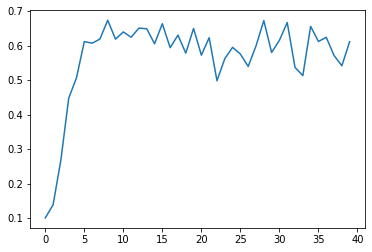

In [14]:
plt.plot(history.history['val_meanAP'])

Calculating Average Precision...: 17it [00:00, 157.73it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:04, 139.27it/s]


Validation meanAP: tf.Tensor(0.6735509126518152, shape=(), dtype=float64)


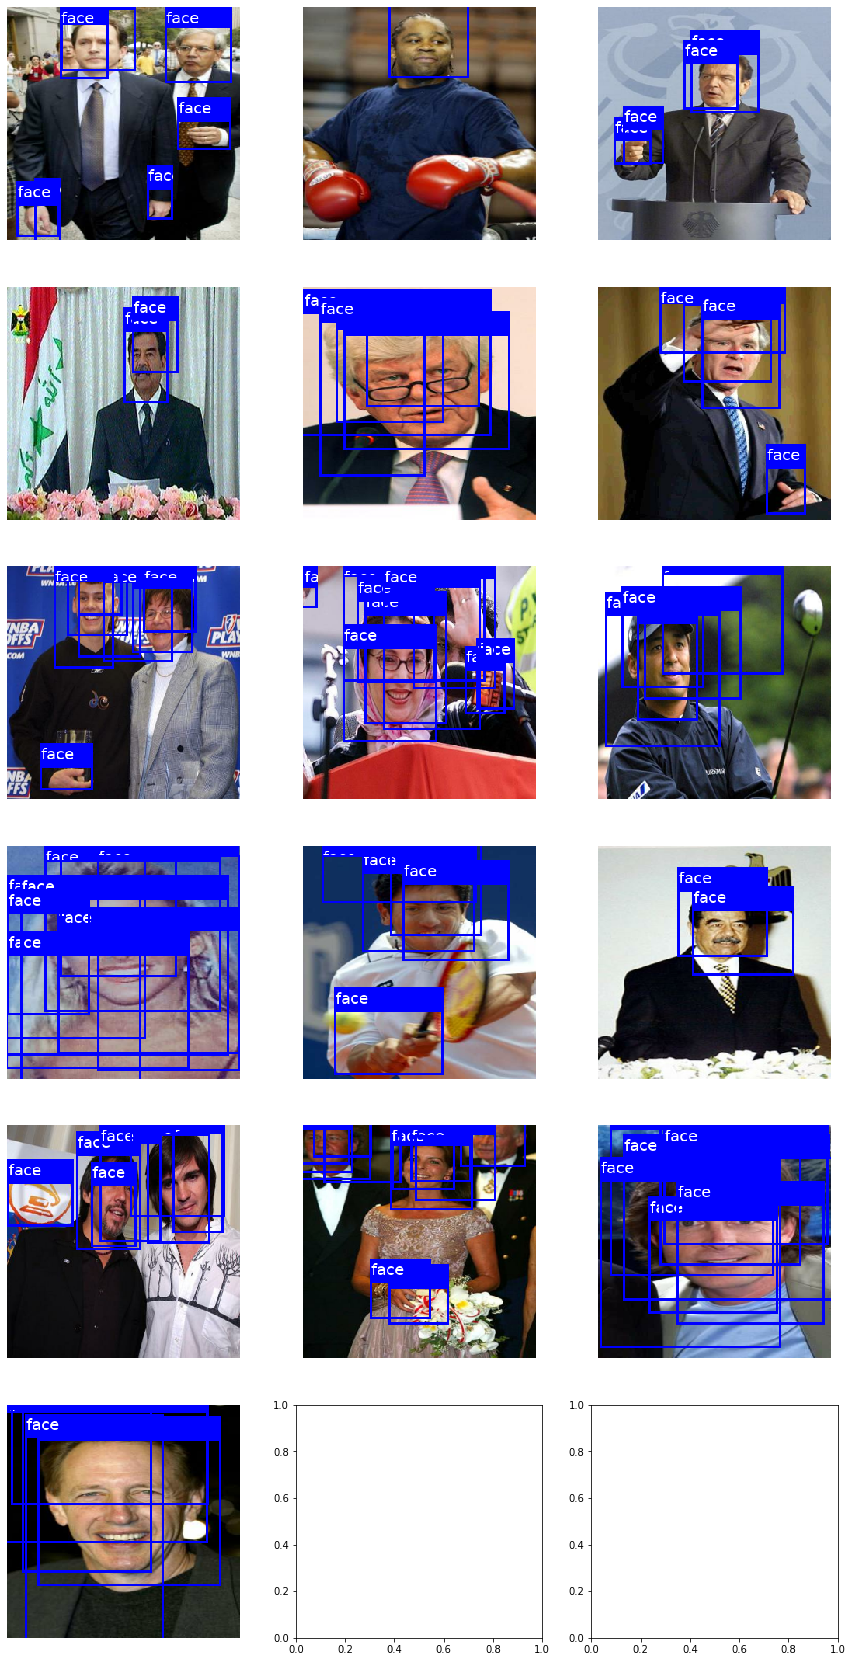

In [15]:
from ssd_utils.metrics import MeanAveragePrecision

mean_AP_metric = MeanAveragePrecision()

model_file = 'resnet50_pretrain.h5'
model.load_weights(model_file)

for x, y_true in valid_data:
    predictions = [output_encoder.decode(y, anchors, model)
                   for y in model(x)]
    ground_truth = [y.to_tensor() for y in y_true]
    mean_AP_metric.update_state(ground_truth, predictions)

print('Validation meanAP:', mean_AP_metric.result())
mean_AP_metric.reset_state()     

num_display = 16
num_cols = 3
num_rows = (num_display+num_cols-1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

X, Y = next(iter(valid_data))
Y_pred = model(X)

for idx in range(num_display):
    x = X[idx]
    y = output_encoder.decode(Y_pred[idx], anchors, model)
    display_image(x, y, ax=fig.axes[idx])
    
plt.show()


### Fintetune the model on real data

In [16]:
from ssd_utils.ssd_loss import SSDLoss
from ssd_utils.metrics import MeanAveragePrecision
from tensorflow.keras.callbacks import ModelCheckpoint

from ssd_utils import output_encoder
from utils import MeanAveragePrecisionCallback

ssd_loss = SSDLoss()
        
meanAP_callback = MeanAveragePrecisionCallback(data=valid_data,
                                               anchors=anchors)

ckpt_callback = ModelCheckpoint('resnet50_finetune.h5',
                                monitor='val_meanAP',
                                mode='max',
                                save_best_only=True,
                                save_weights_only=True)        

        
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=ssd_loss)

history = model.fit(train_data, epochs=config.NUM_EPOCHS,
          steps_per_epoch=config.STEPS_PER_EPOCH,
          callbacks=[meanAP_callback, ckpt_callback])

Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 1.5590

Calculating Average Precision...: 43it [00:00, 418.77it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 344.23it/s]


25/25 [==============================] - 34s 1s/step - loss: 1.5590 - val_meanAP: 0.7710
Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 1.1173

Calculating Average Precision...: 34it [00:00, 331.95it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 354.06it/s]


25/25 [==============================] - 78s 3s/step - loss: 1.1173 - val_meanAP: 0.8222
Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 0.9346

Calculating Average Precision...: 44it [00:00, 431.09it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 426.78it/s]

25/25 [==============================] - 70s 3s/step - loss: 0.9346 - val_meanAP: 0.8207


Epoch 4/20
25/25 [==============================] - ETA: 0s - loss: 0.8021

Calculating Average Precision...: 55it [00:00, 545.90it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 523.82it/s]


25/25 [==============================] - 61s 2s/step - loss: 0.8021 - val_meanAP: 0.8355
Epoch 5/20
25/25 [==============================] - ETA: 0s - loss: 0.6405

Calculating Average Precision...: 54it [00:00, 529.97it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 512.08it/s]


25/25 [==============================] - 31s 1s/step - loss: 0.6405 - val_meanAP: 0.8493
Epoch 6/20
25/25 [==============================] - ETA: 0s - loss: 0.4939

Calculating Average Precision...: 54it [00:00, 494.26it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 565.70it/s]


25/25 [==============================] - 29s 1s/step - loss: 0.4939 - val_meanAP: 0.8554
Epoch 7/20
25/25 [==============================] - ETA: 0s - loss: 0.5483

Calculating Average Precision...: 54it [00:00, 538.00it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 517.32it/s]


25/25 [==============================] - 29s 1s/step - loss: 0.5483 - val_meanAP: 0.8604
Epoch 8/20
25/25 [==============================] - ETA: 0s - loss: 0.4551

Calculating Average Precision...: 54it [00:00, 510.33it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 531.08it/s]


25/25 [==============================] - 29s 1s/step - loss: 0.4551 - val_meanAP: 0.8701
Epoch 9/20
25/25 [==============================] - ETA: 0s - loss: 0.4133

Calculating Average Precision...: 48it [00:00, 476.90it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 471.95it/s]


25/25 [==============================] - 30s 1s/step - loss: 0.4133 - val_meanAP: 0.8731
Epoch 10/20
25/25 [==============================] - ETA: 0s - loss: 0.3280

Calculating Average Precision...: 50it [00:00, 495.16it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 526.36it/s]

25/25 [==============================] - 28s 1s/step - loss: 0.3280 - val_meanAP: 0.8688


Epoch 11/20
25/25 [==============================] - ETA: 0s - loss: 0.3557

Calculating Average Precision...: 47it [00:00, 469.11it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 469.86it/s]

25/25 [==============================] - 29s 1s/step - loss: 0.3557 - val_meanAP: 0.8693


Epoch 12/20
25/25 [==============================] - ETA: 0s - loss: 0.2873

Calculating Average Precision...: 45it [00:00, 432.15it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 489.95it/s]

25/25 [==============================] - 28s 1s/step - loss: 0.2873 - val_meanAP: 0.8669


Epoch 13/20
25/25 [==============================] - ETA: 0s - loss: 0.2610

Calculating Average Precision...: 51it [00:00, 507.05it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 485.37it/s]


25/25 [==============================] - 30s 1s/step - loss: 0.2610 - val_meanAP: 0.8733
Epoch 14/20
25/25 [==============================] - ETA: 0s - loss: 0.2622

Calculating Average Precision...: 53it [00:00, 529.21it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 482.01it/s]

25/25 [==============================] - 28s 1s/step - loss: 0.2622 - val_meanAP: 0.8730


Epoch 15/20
25/25 [==============================] - ETA: 0s - loss: 0.2477

Calculating Average Precision...: 52it [00:00, 518.05it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 458.76it/s]


25/25 [==============================] - 30s 1s/step - loss: 0.2477 - val_meanAP: 0.8781
Epoch 16/20
25/25 [==============================] - ETA: 0s - loss: 0.2275

Calculating Average Precision...: 45it [00:00, 434.62it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 508.53it/s]

25/25 [==============================] - 28s 1s/step - loss: 0.2275 - val_meanAP: 0.8704


Epoch 17/20
25/25 [==============================] - ETA: 0s - loss: 0.2436

Calculating Average Precision...: 41it [00:00, 407.08it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 425.08it/s]

25/25 [==============================] - 29s 1s/step - loss: 0.2436 - val_meanAP: 0.8740


Epoch 18/20
25/25 [==============================] - ETA: 0s - loss: 0.2485

Calculating Average Precision...: 50it [00:00, 497.37it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 471.47it/s]


25/25 [==============================] - 30s 1s/step - loss: 0.2485 - val_meanAP: 0.8784
Epoch 19/20
25/25 [==============================] - ETA: 0s - loss: 0.2194

Calculating Average Precision...: 53it [00:00, 525.92it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 443.12it/s]

25/25 [==============================] - 29s 1s/step - loss: 0.2194 - val_meanAP: 0.8753


Epoch 20/20
25/25 [==============================] - ETA: 0s - loss: 0.1996

Calculating Average Precision...: 45it [00:00, 442.36it/s]


Calculating Average Precision for class 1.0


Calculating Average Precision...: 581it [00:01, 470.49it/s]

25/25 [==============================] - 29s 1s/step - loss: 0.1996 - val_meanAP: 0.8777


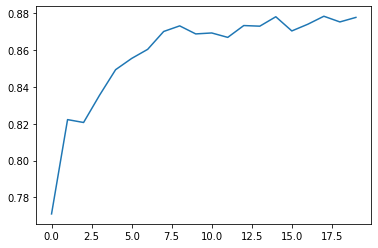

In [17]:
plt.plot(history.history['val_meanAP'])

In [ ]:
from ssd_utils.metrics import MeanAveragePrecision

mean_AP_metric = MeanAveragePrecision()

model_file = 'resnet50_finetune.h5'
model.load_weights(model_file)

for x, y_true in valid_data:
    predictions = [output_encoder.decode(y, anchors, model)
                   for y in model(x)]
    ground_truth = [y.to_tensor() for y in y_true]
    mean_AP_metric.update_state(ground_truth, predictions)

print('Validation meanAP:', mean_AP_metric.result())
mean_AP_metric.reset_state()     

num_display = 16
num_cols = 3
num_rows = (num_display+num_cols-1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

X, Y = next(iter(valid_data))
Y_pred = model(X)

for idx in range(num_display):
    x = X[idx]
    y = output_encoder.decode(Y_pred[idx], anchors, model)
    display_image(x, y, ax=fig.axes[idx])
    
plt.show()